<a href="https://colab.research.google.com/github/AnmolBansal10/Sales-Forecasting-and-Predictions/blob/main/sales_forecast_XGBOOST_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Import required libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# Load the dataset
data = pd.read_csv('train.csv', parse_dates=['date'])
data.set_index('date', inplace=True)

# Display the first few rows
data.head(10)


,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


Feature engineering

In [4]:
# Create a differenced series to make it stationary
data['sales_diff'] = data['sales'].diff()
data.dropna(inplace=True)

# Function to create supervised data from time series
def create_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# Create supervised data with a lag of 12 (for 12 months)
supervised_data = create_supervised(data['sales_diff'], 12)


Train-Test Split and Scaling

In [5]:
# Split data into training and testing sets
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]

# Scale features to fit between -1 and 1
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

# Split data into inputs and outputs
x_train, y_train = train_data[:, 1:], train_data[:, 0]
x_test, y_test = test_data[:, 1:], test_data[:, 0]

# Reshape target variables to be compatible
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)


Define Dates for Predictions and Actual Sales

In [6]:
# Set up dates and actual sales for later comparison
sales_dates = data.index[-13:].to_series().reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates, columns=['date'])

# Get actual sales values for the last 13 months
actual_sales = data['sales'].values[-13:]


Train the XGBoost Model

In [7]:
# Initialize and train the XGBoost Regressor
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=0)
xgb_model.fit(x_train, y_train.ravel())

# Generate predictions for the test set
xgb_predict = xgb_model.predict(x_test)


In [8]:
print(xgb_predict)

[0.31707636 0.23850988 0.2771658  0.22071834 0.04621788 0.2705845
 0.03619117 0.17307937 0.4098887  0.14066137 0.35234046 0.08444854]


Inverse Transform and Calculate Sales Predictions

In [9]:
# Inverse transform to the original scale
xgb_predict = scaler.inverse_transform(np.concatenate((xgb_predict.reshape(-1, 1), x_test), axis=1))[:, 0]

# Calculate the predicted sales values by adding differenced values back
result_list = []
for index in range(len(xgb_predict)):
    result_list.append(xgb_predict[index] + actual_sales[index])

# Create a Series for predicted values
xgb_predict_series = pd.Series(result_list, name='xgb_prediction')

# Add predictions to the DataFrame
predict_df = predict_df.join(xgb_predict_series)


In [10]:
print(predict_df)

         date  xgb_prediction
0  2017-12-19       63.878334
1  2017-12-20       53.846634
2  2017-12-21       69.306339
3  2017-12-22       76.254291
4  2017-12-23       55.636500
5  2017-12-24       81.717312
6  2017-12-25       35.739110
7  2017-12-26       37.990604
8  2017-12-27       81.185040
9  2017-12-28       53.089193
10 2017-12-29       87.034471
11 2017-12-30       51.058144
12 2017-12-31             NaN


Model Evaluation

In [11]:
# Evaluate the XGBoost model
xgb_mse = np.sqrt(mean_squared_error(actual_sales[-12:], xgb_predict))
xgb_mae = mean_absolute_error(actual_sales[-12:], xgb_predict)
xgb_r2 = r2_score(actual_sales[-12:], xgb_predict)

print(f"XGBoost MSE: {xgb_mse}")
print(f"XGBoost MAE: {xgb_mae}")
print(f"XGBoost R2 Score: {xgb_r2}")


XGBoost MSE: 65.56182324071881
XGBoost MAE: 63.272002253991865
XGBoost R2 Score: -30.782427933104238


Plotting Actual Sales vs. Predicted Sales

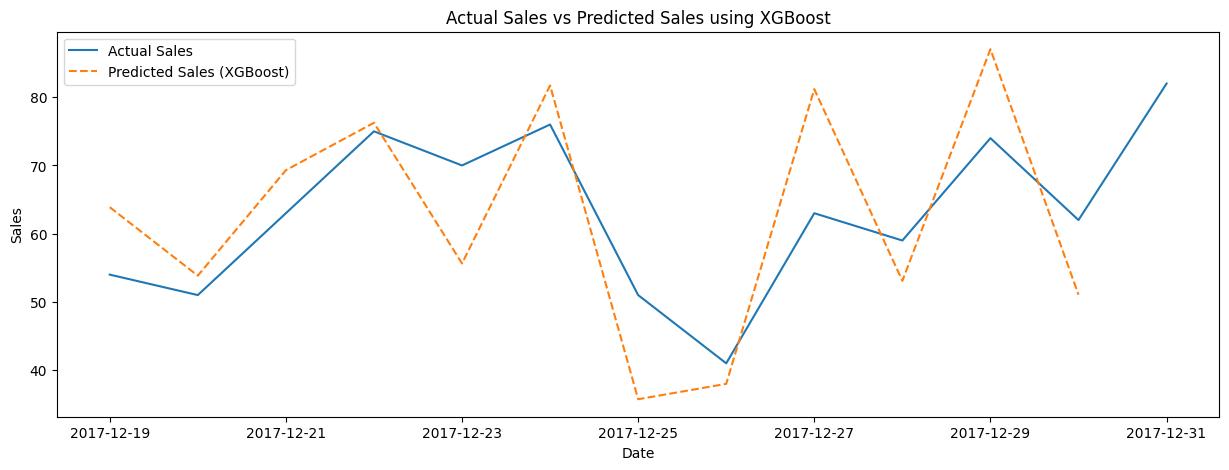

In [12]:
# Plot actual sales vs. predicted sales
plt.figure(figsize=(15, 5))
plt.plot(data.index[-13:], actual_sales, label='Actual Sales')
plt.plot(predict_df['date'], predict_df['xgb_prediction'], label='Predicted Sales (XGBoost)', linestyle='--')
plt.title('Actual Sales vs Predicted Sales using XGBoost')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()
